-------------------------

The Data Harvester enables researchers with reusable workflows for automatic data extraction from a range of data sources including spatial-temporal processing into useable formats. User provided data is auto-completed with a suitable set of spatial- and temporal-aligned covariates as a ready-made dataset for machine learning and agriculture models. In addition, all requested data layer maps are automatically extracted and aligned for a specific region and time period. 

The main workflow of the Harvester is as follows: 

1) Options and user settings (e.g., data layer selections, spatial coverage, temporal constraints, i/o directory names) are defined by the user in the notebook settings menu or can be loaded with a settings yaml file (e.g., settings/settings_v0.2_saved.yaml). All settings are also saved in a yaml file for reusability.
2) The notebook imports settings and all Python modules that include functionality to download and extract data for each data source. After settings are read in, checked, and processed into valid data retrieval (API) queries, all selected data layers are sequentially downloaded and then processed into a clean dataframe table and co-registered raster maps. The entire workflow can be run either completely automatically or individually by selecting only certain process parts in the Notebook.

Additional data sources can be best added by writing the API handlers and extraction functionalities as separate Python module, which are then imported by the Notebook. Currently the following data sources are supported by the following modules:

- 'getdata_slga.py': Soil Data from Soil and Landscape Grid of Australia (SLGA)
- 'getdata_landscape': Landscape data from Soil and Landscape Grid of Australia (SLGA)
- 'getdata_silo.py': Climate Data from SILO
- 'getdata_dem.py: 'National Digital Elevation Model (DEM) 1 Second plus Slope and Apect calculation
- 'getdata_dea_nci.py: 'Digital Earth Australia's (DEA) Geoscience Earth Observations via NCI server
- 'getdata_dea.py: 'Digital Earth Australia's (DEA) Geoscience Earth Observations via Open Web Service server provided by DEA
- 'getdata_radiometric.py': Geoscience Australia National Geophysical Compilation Sub-collection Radiometrics
- 'eeharvest': Google Earth Engine API integration handler, note this is its own package.


## Import libraries


In [1]:
# Load general python libraries
import os
import time
from datetime import datetime
from os.path import exists
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from types import SimpleNamespace

# Load geodata_harvester modules/functions/packages
# See each python file for detailed options
import geodata_harvester as gh

import eeharvest
from geodata_harvester import utils
from geodata_harvester.arc2meter import calc_arc2meter
from geodata_harvester.utils import init_logtable, update_logtable
from geodata_harvester.widgets import harvesterwidgets as hw

## DIY settings configuration file

Let's start with loading all user settings and options as specified in the settings file. For this example we provide a template file `data/settings_session1.yaml`. You can use the default settings in this file. 
Or you may changed the file directly, or point to a new file.
Or override any of the defaults throughout this notebook.
This is the core piece of the Data Harvester that makes the data collection reproduceable. You could give the settings file to someone else and they will end up with the same data collections.

In [2]:
# Build your own settings file with interactive widgets
tab_nest, w_settings, names_settings, w_load = hw.gen_maintab()
display(tab_nest) 
time.sleep(2)

When we have finished either loading in the settings file or choosing custom options we can validate the settings with the below code snippet:

In [4]:
if w_load.value == None:
    dict_settings = hw.eval_widgets(w_settings, names_settings)
    # Convert settings from dictionary to SimpleNamespace (so all settings names available as settings.xxxname)
    settings = SimpleNamespace(**dict_settings)
    # Check if output path exists, if not create it:
    os.makedirs(settings.outpath, exist_ok=True) 
    # Save settings to yaml file:
    fname_settings = os.path.join(settings.outpath, 'settings_saved.yaml')
    hw.save_dict_settings(dict_settings, fname_settings)
else:
    print(f'Settings loaded from {w_load.value}')
    settings = hw.load_settings(w_load.value)
# Print settings
hw.print_settings(settings)

Settings loaded from /home/nbutter/Projects/testing/AgReFed-Workshop/data/settings_session3.yaml
Settings loaded:
----------------
settings.infile : data/example-site_llara.csv
settings.outpath : output/
settings.colname_lat : Lat
settings.colname_lng : Long
settings.target_bbox : [149.769345, -30.335861, 149.949173, -30.206271]
settings.target_res : 6.0
settings.date_min : 2022-10-01
settings.date_max : 2022-10-30
settings.time_intervals : 4
settings.time_buffer : 7
settings.target_sources:
   'DEA': ['landsat_barest_earth', 'ga_ls_ard_3']
   'DEM': ['DEM']
   'Landscape': ['Slope', 'Aspect', 'Relief_300m']
   'Radiometric': ['radmap2019_grid_dose_terr_awags_rad_2019', 'radmap2019_grid_dose_terr_filtered_awags_rad_2019']
   'SILO': {'daily_rain': 'mean', 'max_temp': 'median', 'min_temp': 'median', 'monthly_rain': 'sum'}
   'SLGA': {'Bulk_Density': ['0-5cm'], 'Clay': ['0-5cm']}
   'GEE': {'preprocess': {'collection': 'LANDSAT/LC09/C02/T1_L2', 'coords': None, 'date': datetime.date(2021,

In [ ]:
# For the automated people you can also run something like...
# load_settingsfilename = 'data/settings_session1.yaml'
# settings = hw.load_settings(load_settingsfilename)

## Setup dataset of interest

Here we are reading in the point locations for which we want to extract data. A custom bounding box for which to extract raster data can be set in the settings file. If no bounding box provided, rasters are extracted for the region given by the point location extent plus an additional padding of 0.05 deg in Lat/Long (see code below).

In [5]:
# Load in the dataset defining our location of interest as a geopandas dataframe
gdfpoints = gpd.read_file(settings.infile)

# Assing the data to well-named variables
lngs = gdfpoints[settings.colname_lng].astype(float)
lats = gdfpoints[settings.colname_lat].astype(float)

# Check the data looks reasonable
gdfpoints

,Lat,Long,geometry
0,-30.264663,149.85268,None
1,-30.265302,149.884838,None
2,-30.265302,149.884838,None
3,-30.278542,149.838791,None
4,-30.275437,149.830843,None
...,...,...,...
77,-30.268262,149.87615,None
78,-30.257031,149.880983,None
79,-30.258505,149.891118,None
80,-30.261989,149.884329,None


In [6]:
print(f'Info: Selected bounding box: {settings.target_bbox}')

# Estimate resolution in meters:
lat_center = (settings.target_bbox[1]+settings.target_bbox[3])/2
xres_meters, yres_meters = calc_arc2meter(settings.target_res, lat_center)
print(f'Info: {settings.target_res} arcsec resolution corresponds to {xres_meters:.1f}m x {yres_meters:.1f}m in x,y direction respectively (at Latitude: {lat_center:.2f}).')

Info: Selected bounding box: [149.769345, -30.335861, 149.949173, -30.206271]
Info: 6.0 arcsec resolution corresponds to 160.2m x 185.2m in x,y direction respectively (at Latitude: -30.27).


## Download and process data from API sources

From here we automatically download and process sequentially a range of data sources as specified in the settings file (see next subsections: SLGA, SILO, DEA, DEM). Note that you may retrieve info and parameter input options for any function easily by running a function/method with a preceeding '?', e.g:
```
?getdata_slga.get_slga_layers
?utils
```

In [7]:
# Initiate a dataframe for logging all data output names and layer titles.
# Note that the log table is later updated with update_logtable(), 
# which also instantly saves a copy of the table of the current status.
df_log = init_logtable()

### SLGA Download

Here we download all requested data layers from the Soil and Landscape Grid of Australia (SLGA) for the given bounding box. Note that for this example we select the top soil (0 - 5cm) only. Optionally other layers and depths including confidence intervals can be extracted as well; for more details and options see getdata_slga.py.

In [8]:
# We can set the input options for each function call, and additional parameters may be set
# too. Check the documentation of each function for full list of options.
depth_min, depth_max = gh.getdata_slga.identifier2depthbounds(list(settings.target_sources['SLGA'].values())[0])
slga_layernames = list(settings.target_sources['SLGA'].keys())

fnames_out_slga = gh.getdata_slga.get_slga_layers(
    slga_layernames, 
    settings.target_bbox, 
    settings.outpath, 
    depth_min = depth_min, 
    depth_max= depth_max, 
    get_ci = True)

⚑ SLGA_Bulk_Density_0-5cm.tif already exists, skipping download
⚑ SLGA_Bulk_Density_0-5cm_5percentile.tif already exists, skipping download
⚑ SLGA_Bulk_Density_0-5cm_95percentile.tif already exists, skipping download
⚑ SLGA_Clay_0-5cm.tif already exists, skipping download
⚑ SLGA_Clay_0-5cm_5percentile.tif already exists, skipping download
⚑ SLGA_Clay_0-5cm_95percentile.tif already exists, skipping download


In [9]:
# Add download info to log dataframe
df_log = update_logtable(
    df_log, 
    fnames_out_slga, 
    slga_layernames, 
    'SLGA', 
    settings, 
    layertitles = [], loginfos = 'downloaded')
df_log

,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,output/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,Clay,0-5cm,SLGA,Clay_0-5cm,output/SLGA_Clay_0-5cm.tif,downloaded


### SILO Download

Here we download climate data layers from SILO and extract raster for the given bounding box and year.
For more details see getdata_silo.py

In [10]:
# Each data-source must be handled differently (as the data is stored in different ways)
# Here we must get each layer, one by one. The simplest way is to loop through them.
# Get data for each layer
outpath = settings.outpath+'_silo'
silo_layernames = list(settings.target_sources['SILO'].keys())
# run the download
fnames_out_silo = gh.getdata_silo.get_SILO_layers(
    silo_layernames, 
    settings.date_min, 
    settings.date_max,
    outpath, 
    bbox = settings.target_bbox, 
    format_out = 'tif')

# Add download info to log dataframe
# TBD need to be tested for multiple years and not only one
if len(fnames_out_silo) > len(silo_layernames):
    # TBD Temporary solution for multiple years:
    nyears = int(len(fnames_out_silo)/len(silo_layernames))
    silo_layernames = silo_layernames * nyears
df_log = update_logtable(df_log, fnames_out_silo, silo_layernames, 'SILO', settings, layertitles = [], loginfos = 'downloaded')
df_log

⊙ Downloading daily_rain for 2022 9.0s                                                                                  
⊙ Downloading max_temp for 2022 8.7s                                                                                    
⊙ Downloading min_temp for 2022 10.1s                                                                                   
⊙ Downloading monthly_rain for 2022 0.7s                                                                                


,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,output/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,Clay,0-5cm,SLGA,Clay_0-5cm,output/SLGA_Clay_0-5cm.tif,downloaded
2,daily_rain,mean,SILO,daily_rain_mean,output/_silo/silo_daily_rain_2022-10-01-2022-1...,downloaded
3,max_temp,median,SILO,max_temp_median,output/_silo/silo_max_temp_2022-10-01-2022-10-...,downloaded
4,min_temp,median,SILO,min_temp_median,output/_silo/silo_min_temp_2022-10-01-2022-10-...,downloaded
5,monthly_rain,sum,SILO,monthly_rain_sum,output/_silo/silo_monthly_rain_2022-10-01-2022...,downloaded


### DEA Download

Here we download satellite data from Digital Earth Australia (DEA) within the given bounding box and for all available image capture dates that are available within the specified year(s). For more details see getdata_dea.py or getdata_dea_nci
.py

In [11]:
dea_layernames = settings.target_sources['DEA']

# These are multiple files, so we put them in a subdirectory to make subsequent processing easier.
outpath_dea = os.path.join(settings.outpath,'mvp_dea')

outfnames = gh.getdata_dea.get_dea_layers_daterange(
    dea_layernames, 
    settings.date_min,
    settings.date_max,
    settings.target_bbox, 
    settings.target_res, 
    outpath_dea, 
    crs = 'EPSG:4326', 
    format_out = 'GeoTIFF')

⊙ Downloading landsat_barest_earth.tif for None 2.6s                                                                    
⊙ Downloading ga_ls_ard_3.tif for 2022-10-01T00:00:00.000Z 0.3s                                                         
⊙ Downloading ga_ls_ard_3.tif for 2022-10-02T00:00:00.000Z 0.2s                                                         
⊙ Downloading ga_ls_ard_3.tif for 2022-10-03T00:00:00.000Z 0.4s                                                         
⊙ Downloading ga_ls_ard_3.tif for 2022-10-04T00:00:00.000Z 0.5s                                                         
⊙ Downloading ga_ls_ard_3.tif for 2022-10-05T00:00:00.000Z 2.0s                                                         
⊙ Downloading ga_ls_ard_3.tif for 2022-10-06T00:00:00.000Z 0.2s                                                         
⊙ Downloading ga_ls_ard_3.tif for 2022-10-07T00:00:00.000Z 0.2s                                                         
⊙ Downloading ga_ls_ard_3.tif fo

In [12]:
# We must do some annoying Python manipulations here, 
# simply to get things into the correct format for our logfile
layer_list = []
for layername in dea_layernames:
    s = sum(layername in s for s in outfnames)
    l = [layername]*s
    layer_list.append(l)

layer_list  = sum(layer_list, [])

layer_titles = [os.path.splitext(x)[0].split('/')[-1] for x in outfnames]

In [13]:
# Add extracted data info to log table
df_log = update_logtable(
    df_log, 
    outfnames, 
    layer_titles, 
    'DEA', 
    settings, 
    layertitles = layer_titles, 
    loginfos = 'processed',force=True)
#print(df_log.layertitle)
df_log

,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,output/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,Clay,0-5cm,SLGA,Clay_0-5cm,output/SLGA_Clay_0-5cm.tif,downloaded
2,daily_rain,mean,SILO,daily_rain_mean,output/_silo/silo_daily_rain_2022-10-01-2022-1...,downloaded
3,max_temp,median,SILO,max_temp_median,output/_silo/silo_max_temp_2022-10-01-2022-10-...,downloaded
4,min_temp,median,SILO,min_temp_median,output/_silo/silo_min_temp_2022-10-01-2022-10-...,downloaded
5,monthly_rain,sum,SILO,monthly_rain_sum,output/_silo/silo_monthly_rain_2022-10-01-2022...,downloaded
6,landsat_barest_earth,None,DEA,landsat_barest_earth,output/mvp_dea/landsat_barest_earth.tif,processed
7,ga_ls_ard_3_2022-9-30,None,DEA,ga_ls_ard_3_2022-9-30,output/mvp_dea/ga_ls_ard_3_2022-9-30.tif,processed
8,ga_ls_ard_3_2022-10-1,None,DEA,ga_ls_ard_3_2022-10-1,output/mvp_dea/ga_ls_ard_3_2022-10-1.tif,processed
9,ga_ls_ard_3_2022-10-2,None,DEA,ga_ls_ard_3_2022-10-2,output/mvp_dea/ga_ls_ard_3_2022-10-2.tif,processed


### DEM Download

Here we download and extract the National Digital Elevation Model (DEM), and also generate slope and aspect rasters from the extracted DEM. 
For more details see getdata_dem.py

In [14]:
outpath = os.path.join(settings.outpath, "mvp_dem")
dem_layernames = settings.target_sources['DEM']
outfnames = gh.getdata_dem.get_dem_layers(dem_layernames, outpath, settings.target_bbox, settings.target_res)

# Add extracted data to log dataframe
df_log = update_logtable(
    df_log, 
    outfnames, 
    dem_layernames, 
    'DEM', 
    settings, 
    layertitles = dem_layernames,
    loginfos = 'downloaded')
df_log

⊙ Retrieving coverage from WCS server 3.6s                                                                              
⊙ Downloading DEM_SRTM_1_Second_Hydro_Enforced_2023_01_31.tif 1.0s                                                      


,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,output/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,Clay,0-5cm,SLGA,Clay_0-5cm,output/SLGA_Clay_0-5cm.tif,downloaded
2,daily_rain,mean,SILO,daily_rain_mean,output/_silo/silo_daily_rain_2022-10-01-2022-1...,downloaded
3,max_temp,median,SILO,max_temp_median,output/_silo/silo_max_temp_2022-10-01-2022-10-...,downloaded
4,min_temp,median,SILO,min_temp_median,output/_silo/silo_min_temp_2022-10-01-2022-10-...,downloaded
5,monthly_rain,sum,SILO,monthly_rain_sum,output/_silo/silo_monthly_rain_2022-10-01-2022...,downloaded
6,landsat_barest_earth,None,DEA,landsat_barest_earth,output/mvp_dea/landsat_barest_earth.tif,processed
7,ga_ls_ard_3_2022-9-30,None,DEA,ga_ls_ard_3_2022-9-30,output/mvp_dea/ga_ls_ard_3_2022-9-30.tif,processed
8,ga_ls_ard_3_2022-10-1,None,DEA,ga_ls_ard_3_2022-10-1,output/mvp_dea/ga_ls_ard_3_2022-10-1.tif,processed
9,ga_ls_ard_3_2022-10-2,None,DEA,ga_ls_ard_3_2022-10-2,output/mvp_dea/ga_ls_ard_3_2022-10-2.tif,processed


### Landscape

Download landscape data from Soil and Landscape Grid of Australia (SLGA).

In [15]:
# Download landscape data
layernames = settings.target_sources['Landscape']
layertitles = ['Landscape_' + layername for layername in layernames]

outfnames = gh.getdata_landscape.get_landscape_layers(
    layernames, 
    settings.target_bbox, 
    settings.outpath, 
    resolution = settings.target_res)

# Add extracted data to log dataframe
df_log = update_logtable(
    df_log, outfnames, 
    layernames, 
    'Landscape', 
    settings, 
    layertitles = layertitles,
    loginfos = 'downloaded')
df_log


⚑ Landscape_Slope.tif already exists, skipping download
⚑ Landscape_Aspect.tif already exists, skipping download
⚑ Landscape_Relief_300m.tif already exists, skipping download


,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,output/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,Clay,0-5cm,SLGA,Clay_0-5cm,output/SLGA_Clay_0-5cm.tif,downloaded
2,daily_rain,mean,SILO,daily_rain_mean,output/_silo/silo_daily_rain_2022-10-01-2022-1...,downloaded
3,max_temp,median,SILO,max_temp_median,output/_silo/silo_max_temp_2022-10-01-2022-10-...,downloaded
4,min_temp,median,SILO,min_temp_median,output/_silo/silo_min_temp_2022-10-01-2022-10-...,downloaded
5,monthly_rain,sum,SILO,monthly_rain_sum,output/_silo/silo_monthly_rain_2022-10-01-2022...,downloaded
6,landsat_barest_earth,None,DEA,landsat_barest_earth,output/mvp_dea/landsat_barest_earth.tif,processed
7,ga_ls_ard_3_2022-9-30,None,DEA,ga_ls_ard_3_2022-9-30,output/mvp_dea/ga_ls_ard_3_2022-9-30.tif,processed
8,ga_ls_ard_3_2022-10-1,None,DEA,ga_ls_ard_3_2022-10-1,output/mvp_dea/ga_ls_ard_3_2022-10-1.tif,processed
9,ga_ls_ard_3_2022-10-2,None,DEA,ga_ls_ard_3_2022-10-2,output/mvp_dea/ga_ls_ard_3_2022-10-2.tif,processed


### Radiometrics

Download maps of Geoscience Australia National Geophysical Compilation Sub-collection Radiometrics

In [29]:
# Download radiometrics
layernames = settings.target_sources['Radiometric']

outfnames = gh.getdata_radiometric.get_radiometric_layers(
    settings.outpath, 
    layernames, 
    bbox = settings.target_bbox, 
    resolution=settings.target_res)

 # Add extracted data to log dataframe
df_log = update_logtable(
    df_log, outfnames, 
    layernames, 
    'Radiometric', 
    settings, 
    layertitles = layernames,
    loginfos = 'downloaded')
df_log

## Google Earth Engine

To connect to Google Earth Engine, you must already have access to the Google
Earth Engine API. You can request for access [by clicking
here](https://earthengine.google.com/signup/). Once you are authorised, connect
to the API using `initialise()`. A web browser may be invoked to complete the
process.

In [19]:
# Connect to the Google Earth Engine API
eeharvest.initialise(auth_mode = 'notebook')

⊙ Initialising Earth Engine... 2.6s                                                                                     
✔ Earth Engine authenticated


### Collect and preprocess Earth Engine Data

Use `collect()` to define the data object and `preprocess()` to perform server-side
data processing which includes cloud and shadow masking, image reduction and
calculation of spectral indices.

In [20]:
gee = settings.target_sources["GEE"]

# Define the collection, area of interest and date range
img = eeharvest.collect(collection=gee['preprocess']['collection'],
              coords=settings.target_bbox,
              date_min=settings.date_min, 
              date_max = settings.date_max)

# Perform cloud maskng, reduction, and calculate one or more spectral indices
img.preprocess(mask_clouds=gee["preprocess"]["mask_clouds"], 
               reduce=gee["preprocess"]["reduce"], 
               spectral=gee["preprocess"]["spectral"])

Running preprocess() -----
⊙ Applying scale, offset and cloud masks... 0.8s                                                                        
⊙ Calculating spectral indices: NDVI... 0.6s                                                                            
⊙ Reducing image pixels by median 0.0s                                                                                  
✔ Preprocessing complete


### Download

Download the data using `download()` and add to `df_log`:

In [21]:
# Downoad data
img.download(bands=gee["download"]["bands"],
             scale=gee["download"]["scale"],
             outpath=settings.outpath,
             out_format=gee["download"]["format"])


# Add to log dataframe
outfnames = [settings.outpath + img.filenames]
layernames = [Path(img.filenames).resolve().stem]

df_log = update_logtable(
    df_log,
    outfnames,
    layernames,
    "GEE",
    settings,
    layertitles=[],
    agfunctions=img.reduce,
    loginfos="downloaded",
    )

# Preview to log file 
df_log 

Running download() -----
ℹ Band(s) selected: NDVI
ℹ Setting download dir to output/
⊙ Downloading ee_LANDSAT_500ed6ce.tif ▁▃▅ 3s                                                                            

on 0: There is no STAC entry for: None


⊙ Downloading ee_LANDSAT_500ed6ce.tif 2.9s                                                                              
✔ Google Earth Engine download(s) complete


,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,output/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,Clay,0-5cm,SLGA,Clay_0-5cm,output/SLGA_Clay_0-5cm.tif,downloaded
2,daily_rain,mean,SILO,daily_rain_mean,output/_silo/silo_daily_rain_2022-10-01-2022-1...,downloaded
3,max_temp,median,SILO,max_temp_median,output/_silo/silo_max_temp_2022-10-01-2022-10-...,downloaded
4,min_temp,median,SILO,min_temp_median,output/_silo/silo_min_temp_2022-10-01-2022-10-...,downloaded
5,monthly_rain,sum,SILO,monthly_rain_sum,output/_silo/silo_monthly_rain_2022-10-01-2022...,downloaded
6,landsat_barest_earth,None,DEA,landsat_barest_earth,output/mvp_dea/landsat_barest_earth.tif,processed
7,ga_ls_ard_3_2022-9-30,None,DEA,ga_ls_ard_3_2022-9-30,output/mvp_dea/ga_ls_ard_3_2022-9-30.tif,processed
8,ga_ls_ard_3_2022-10-1,None,DEA,ga_ls_ard_3_2022-10-1,output/mvp_dea/ga_ls_ard_3_2022-10-1.tif,processed
9,ga_ls_ard_3_2022-10-2,None,DEA,ga_ls_ard_3_2022-10-2,output/mvp_dea/ga_ls_ard_3_2022-10-2.tif,processed


## Save the final log or start from here to re-load it in.
We have now completed the data download section. You may add additional downlods and processing steps to your log file.

In [22]:
# Save out (or load in) the log file.
logfile = settings.outpath+'log.csv'
if exists(logfile):
    print(logfile, "exists! Do you want to read it in?\n")
    user_input = input("(y)es / (n)o / (a)bort ? Ansering 'no' will overwrite the current file.\n")
    if user_input=='y':
        df_log = pd.read_csv(settings.outpath+'log.csv')
    elif user_input =='n': 
        df_log.to_csv(settings.outpath+'log.csv',index=False)
        print(logfile, "saved!")
    else:
        print("Cancelling read/write for log file.\nFigure out what you want to do and please try again.")
else:
    print("No log file found. Saving to", settings.outpath+'log.csv')
    df_log.to_csv(settings.outpath+'log.csv',index=False)

df_log

No log file found. Saving to output/log.csv


,layername,agfunction,dataset,layertitle,filename_out,loginfo
0,Bulk_Density,0-5cm,SLGA,Bulk_Density_0-5cm,output/SLGA_Bulk_Density_0-5cm.tif,downloaded
1,Clay,0-5cm,SLGA,Clay_0-5cm,output/SLGA_Clay_0-5cm.tif,downloaded
2,daily_rain,mean,SILO,daily_rain_mean,output/_silo/silo_daily_rain_2022-10-01-2022-1...,downloaded
3,max_temp,median,SILO,max_temp_median,output/_silo/silo_max_temp_2022-10-01-2022-10-...,downloaded
4,min_temp,median,SILO,min_temp_median,output/_silo/silo_min_temp_2022-10-01-2022-10-...,downloaded
5,monthly_rain,sum,SILO,monthly_rain_sum,output/_silo/silo_monthly_rain_2022-10-01-2022...,downloaded
6,landsat_barest_earth,None,DEA,landsat_barest_earth,output/mvp_dea/landsat_barest_earth.tif,processed
7,ga_ls_ard_3_2022-9-30,None,DEA,ga_ls_ard_3_2022-9-30,output/mvp_dea/ga_ls_ard_3_2022-9-30.tif,processed
8,ga_ls_ard_3_2022-10-1,None,DEA,ga_ls_ard_3_2022-10-1,output/mvp_dea/ga_ls_ard_3_2022-10-1.tif,processed
9,ga_ls_ard_3_2022-10-2,None,DEA,ga_ls_ard_3_2022-10-2,output/mvp_dea/ga_ls_ard_3_2022-10-2.tif,processed


## Points extraction from downloaded/processed data

By default point values of all processed layers in df_log are extracted given by the input locations. However, you can select also only certain layers (see in code). 

In [23]:
# Select all processed data
df_sel = df_log.copy()

# or select only the rasters of interest, for example:
"""
df_sel = df_log[df_log['layername'].isin(['DEM','Slope',
'landsat8_nbart_16day_channel0', 
'Organic_Carbon','Depth_of_Soil',
'mean_temp','monthly_rain'])]
"""

rasters= df_sel['filename_out'].values.tolist()
titles = df_sel['layertitle'].values.tolist()
    
# Extract datatable from rasters given input coordinates
gdf = utils.raster_query(lngs,lats,rasters,titles)

⊙ • SLGA_Bulk_Density_0-5cm | pixel size: (156, 216) 0.2s                                                               
⊙ • SLGA_Clay_0-5cm | pixel size: (156, 216) 0.0s                                                                       
⊙ • silo_daily_rain_2022-10-01-2022-10-30 | pixel size: (2, 3) 0.0s                                                     
⊙ • silo_max_temp_2022-10-01-2022-10-30 | pixel size: (2, 3) 0.0s                                                       
⊙ • silo_min_temp_2022-10-01-2022-10-30 | pixel size: (2, 3) 0.0s                                                       
⊙ • silo_monthly_rain_2022-10-01-2022-10-30 | pixel size: (2, 3) 0.0s                                                   
⊙ • landsat_barest_earth | pixel size: (77, 107) 0.0s                                                                   
⊙ • ga_ls_ard_3_2022-9-30 | pixel size: (77, 107) 0.0s                                                                  
⊙ • ga_ls_ard_3_2022-10-1 | pixe

### Inspect result dataframe

In [24]:
# Inspect either entire generated dataframe with 
# gdf
# or only the first rows
gdf.head()

,Longitude,Latitude,geometry,Bulk_Density_0-5cm,Clay_0-5cm,daily_rain_mean,max_temp_median,min_temp_median,monthly_rain_sum,landsat_barest_earth,...,ga_ls_ard_3_2022-10-25,ga_ls_ard_3_2022-10-26,ga_ls_ard_3_2022-10-27,ga_ls_ard_3_2022-10-28,ga_ls_ard_3_2022-10-29,DEM,Landscape_Slope,Landscape_Aspect,Landscape_Relief_300m,ee_LANDSAT_500ed6ce_median
0,149.852680,-30.264663,POINT (149.85268 -30.26466),1.368779,27.214527,0.000000,22.700001,9.8,189.500000,1059,...,-999,-999,211,-999,-999,244.658585,1.046624,209.138062,10.463379,0.930875
1,149.884838,-30.265302,POINT (149.88484 -30.26530),1.362662,31.956041,0.199951,22.600000,9.5,189.000000,1082,...,-999,-999,560,-999,-999,264.428772,1.001000,279.542847,6.037811,0.292110
2,149.884838,-30.265302,POINT (149.88484 -30.26530),1.362662,31.956041,0.199951,22.600000,9.5,189.000000,1082,...,-999,-999,560,-999,-999,264.428772,1.001000,279.542847,6.037811,0.292110
3,149.838791,-30.278542,POINT (149.83879 -30.27854),1.360451,32.675858,0.000000,22.900000,10.1,173.199951,1092,...,-999,-999,291,-999,-999,233.005081,0.841430,242.743683,4.798782,0.902620
4,149.830843,-30.275437,POINT (149.83084 -30.27544),1.334362,35.097813,0.000000,22.900000,10.1,173.199951,1160,...,-999,-999,255,-999,-999,230.575439,1.062537,242.921112,5.204880,0.873750


In [25]:
# Get some general info about result table:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Longitude                   82 non-null     float64 
 1   Latitude                    82 non-null     float64 
 2   geometry                    82 non-null     geometry
 3   Bulk_Density_0-5cm          82 non-null     float32 
 4   Clay_0-5cm                  82 non-null     float32 
 5   daily_rain_mean             82 non-null     float32 
 6   max_temp_median             82 non-null     float32 
 7   min_temp_median             82 non-null     float32 
 8   monthly_rain_sum            82 non-null     float32 
 9   landsat_barest_earth        82 non-null     int16   
 10  ga_ls_ard_3_2022-9-30       82 non-null     int16   
 11  ga_ls_ard_3_2022-10-1       82 non-null     int16   
 12  ga_ls_ard_3_2022-10-2       82 non-null     int16   
 13  ga_ls_ard_3_20

### Save the results table

Finally, the result dataframe table is saved as a csv file, which can be used now to do some awesome ML.
In addition the results are also saved as a geo-spatial referenced geopackage (.gpkg), which can be used again as input for further analysis or to inspect and overlay data on other layers and basemaps. The geopackage is a standard georeferenced file format and can be opened with any geo-spatial package or interactive software (e.g., QGIS, Esri ArcGIS). 

In [26]:
# Save the results table to a csv 
gdf.to_csv(os.path.join(settings.outpath, "results.csv"), index = True, mode='w')

# Save also as geopackage
gdf.to_file(os.path.join(settings.outpath, "results.gpkg"), driver="GPKG")
# Note: The deprecated warning below is a bug in geopandas and will be fixed in their bext version.

### Overview plot of all processed rasters 

This provides a quick overview to inspect all processed data layers with an overlay of the requested location points.
  

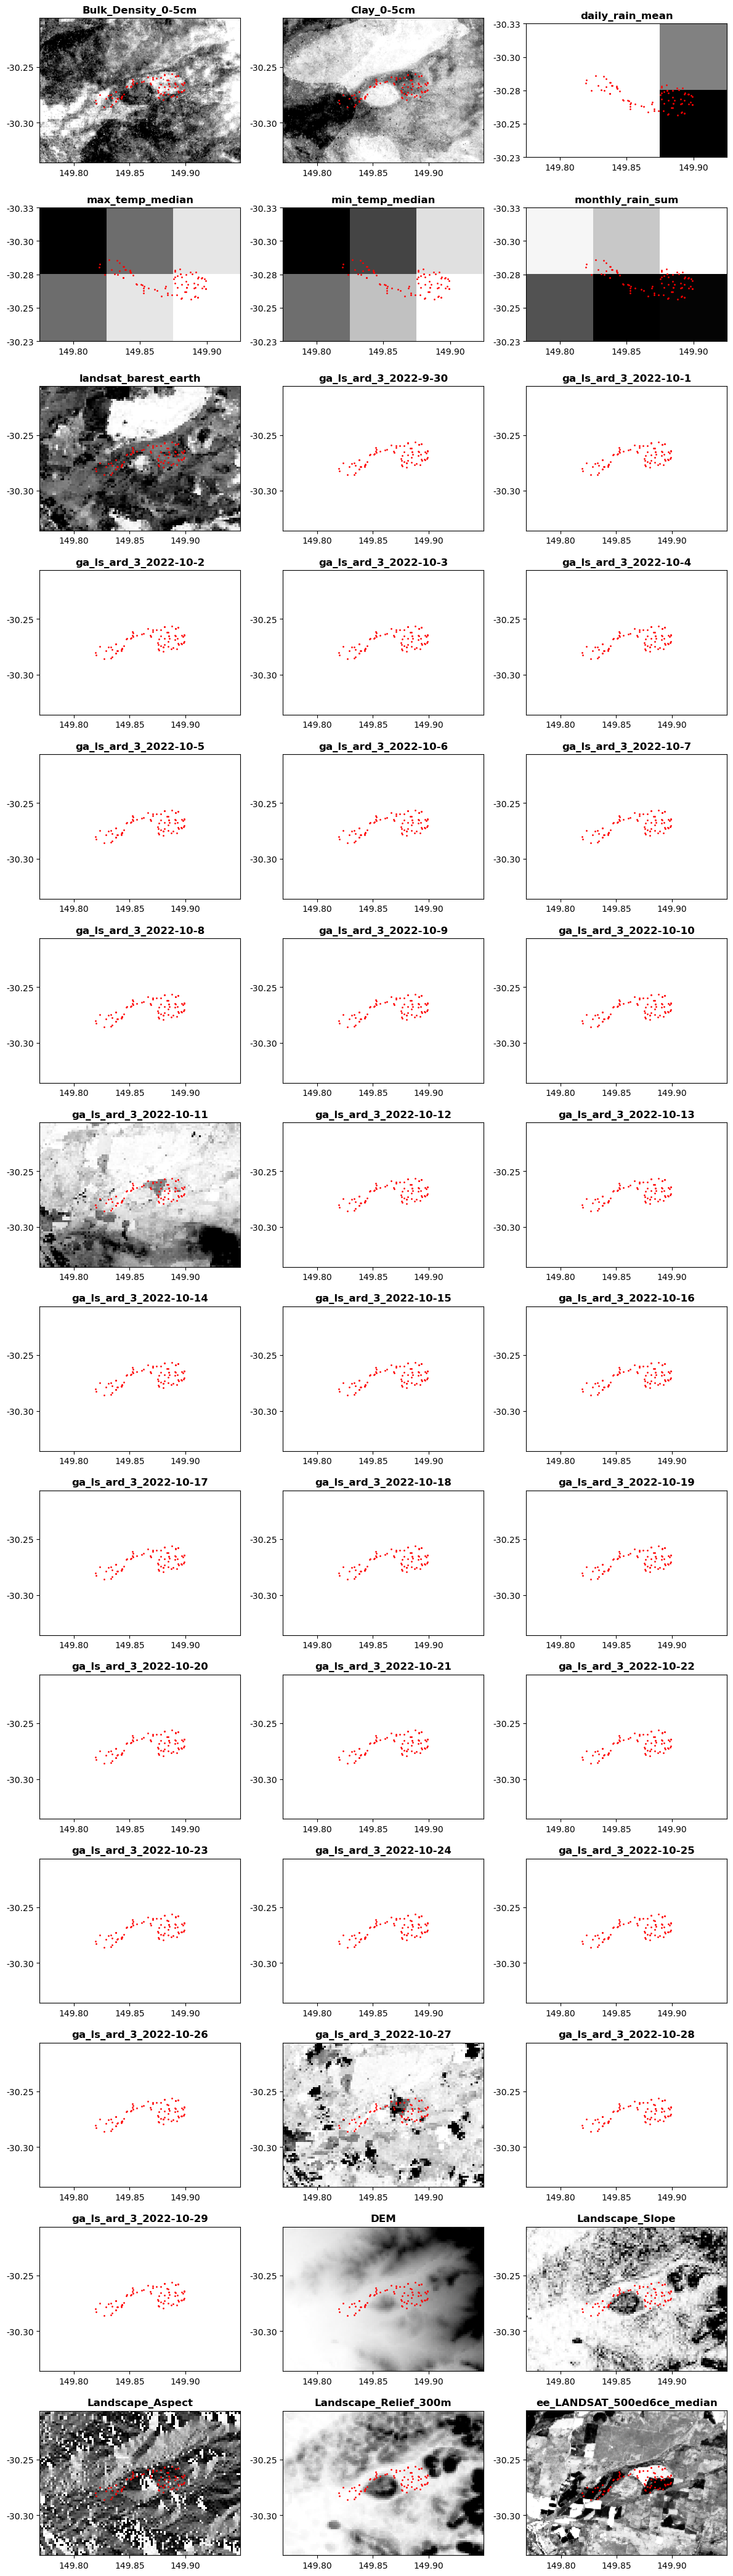

In [27]:
# Plot one of that datasets with the points on top
gh.utils.plot_rasters(rasters,lngs,lats,titles)

# Done!

Now you have seen how aggregrate downloads occur within the `harvest.run` function. You can explore the files that have been output in the browser and take them for furhter analysis in your favourite software.

There are several more light processing tools, options, and functionality availble already for the power-users, which we are gradually exposing to the run function directly callable from the settings file.

Have a workflow you want automated? Or a data source that would be great to have in the Geodata-Harverser? [Submit a feature or issue on the GitHub!](https://github.com/Sydney-Informatics-Hub/geodata-harvester) Or even better, make a pull-request and contribute to open-source software!